# 0. Import


In [38]:
from os import listdir
from matplotlib import image
import numpy as np
from google.colab import drive
from PIL import Image
import zipfile
import re
import matplotlib.pyplot as plt
from keras import backend as K

import tensorflow as tf
from sklearn.preprocessing import normalize
from tensorflow.keras.layers import Input, Dense, Activation,Lambda,Flatten,Dropout, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras import Model
from keras.layers.merge import concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Read data


In [2]:
PATH_ZIP = '/content/drive/My Drive/PROJET F4 ZZ3 HAMZA/Data.zip'
PATH_X = '/content/targetdir/X/'
PATH_Y = '/content/targetdir/Y/'

In [3]:
with zipfile.ZipFile(PATH_ZIP,"r") as zip_ref:
    zip_ref.extractall("targetdir")

In [4]:
def get_image(path):
    l = []
    for i, filename in enumerate(listdir(path)):
        # store loaded image
        l.append(filename)
    l.sort(key=lambda f: int(re.sub('\D', '', f)))
    loaded_images = []
    for i, item in enumerate(l):
        loaded_images.append(np.load(path+item).reshape(1025,1025,1))
    return np.array(loaded_images)

In [5]:
X = get_image(PATH_X)
Y = get_image(PATH_Y)
X.shape

(1556, 1025, 1025, 1)

In [6]:
"""X = X[:, 360:-361, 360:-361]
Y = Y[:, 360:-361, 360:-361]
X.shape"""

'X = X[:, 360:-361, 360:-361]\nY = Y[:, 360:-361, 360:-361]\nX.shape'

In [7]:
"""plt.figure()
f, axarr = plt.subplots(1,5, figsize=(15, 15))

for i in range(5):
    axarr[i].imshow(Y[189+i].reshape(304,304))"""

'plt.figure()\nf, axarr = plt.subplots(1,5, figsize=(15, 15))\n\nfor i in range(5):\n    axarr[i].imshow(Y[189+i].reshape(304,304))'

In [8]:
"""plt.figure()
f, axarr = plt.subplots(1,5, figsize=(15, 15))

for i in range(5):
        axarr[i].imshow(X[189+i].reshape(304,304))"""

'plt.figure()\nf, axarr = plt.subplots(1,5, figsize=(15, 15))\n\nfor i in range(5):\n        axarr[i].imshow(X[189+i].reshape(304,304))'

In [23]:
X_crop = X[:, 360:-505, 465:-480]
Y_crop = Y[:, 360:-505, 465:-480]

In [24]:
X_crop = np.float64(X_crop)

In [25]:
for i in range(len(X_crop)):
    X_crop[i] = (X_crop[i] - np.min(X_crop[i]))/(np.max(X_crop[i])-np.min(X_crop[i]))

<Figure size 432x288 with 0 Axes>

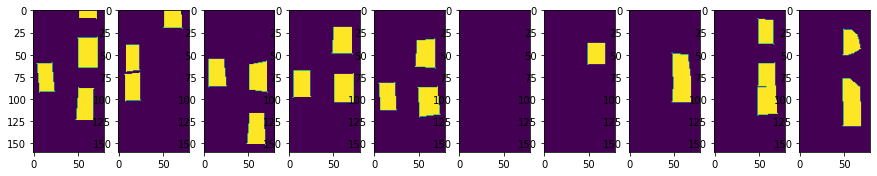

In [26]:
plt.figure()
f, axarr = plt.subplots(1,10, figsize=(15, 15))

for i in range(10):
    axarr[i].imshow(Y_crop[189+i].reshape(160,80))

<Figure size 432x288 with 0 Axes>

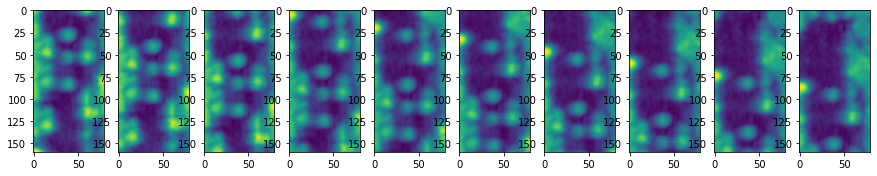

In [28]:
plt.figure()
f, axarr = plt.subplots(1,10, figsize=(15, 15))

for i in range(10):
        axarr[i].imshow(X_crop[189+i].reshape(160,80))

In [15]:
len(Y_crop)

1556

In [29]:
res = 0
for i in range(len(Y_crop)):
    if(1 in Y_crop[i]):
        res += 1
res/len(Y)

0.653598971722365

# 2. UNet + metrics

In [17]:
# https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate

# COMPETITION METRIC
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [30]:
#https://www.kaggle.com/dingli/keras-u-net-for-nuclei-segmentation
inputs = Input((160,80,1))
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 160, 80, 16)  160         ['input_2[0][0]']                
                                                                                                  
 dropout_9 (Dropout)            (None, 160, 80, 16)  0           ['conv2d_19[0][0]']              
                                                                                                  
 conv2d_20 (Conv2D)             (None, 160, 80, 16)  2320        ['dropout_9[0][0]']        

# 3. Train

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_crop, Y_crop, test_size=0.1)

In [32]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, iou_coef])
history = model.fit(X_train,y_train, epochs=40, batch_size=10, validation_data=(X_test,y_test), callbacks=[lr_reduction])

Epoch 1/40
140/140 [==============================] - 7s 31ms/step - loss: 0.1801 - dice_coef: 0.0933 - iou_coef: 0.0365 - val_loss: 0.1469 - val_dice_coef: 0.1219 - val_iou_coef: 0.0459 - lr: 0.0010
Epoch 2/40
140/140 [==============================] - 4s 26ms/step - loss: 0.1440 - dice_coef: 0.1645 - iou_coef: 0.0640 - val_loss: 0.1222 - val_dice_coef: 0.2057 - val_iou_coef: 0.0707 - lr: 0.0010
Epoch 3/40
140/140 [==============================] - 4s 26ms/step - loss: 0.1234 - dice_coef: 0.2675 - iou_coef: 0.1047 - val_loss: 0.1125 - val_dice_coef: 0.2336 - val_iou_coef: 0.0860 - lr: 0.0010
Epoch 4/40
140/140 [==============================] - 4s 26ms/step - loss: 0.1107 - dice_coef: 0.3359 - iou_coef: 0.1333 - val_loss: 0.1088 - val_dice_coef: 0.2866 - val_iou_coef: 0.1153 - lr: 0.0010
Epoch 5/40
140/140 [==============================] - 4s 26ms/step - loss: 0.0957 - dice_coef: 0.4055 - iou_coef: 0.1686 - val_loss: 0.1161 - val_dice_coef: 0.3418 - val_iou_coef: 0.1226 - lr: 0.0010


In [33]:
model.save('/content/drive/My Drive/PROJET F4 ZZ3 HAMZA/UNET.h5')

In [45]:
Y_pred = load_model('/content/drive/My Drive/PROJET F4 ZZ3 HAMZA/UNET.h5', custom_objects={"dice_coef": dice_coef, "iou_coef": iou_coef }).predict(X_test)

<Figure size 432x288 with 0 Axes>

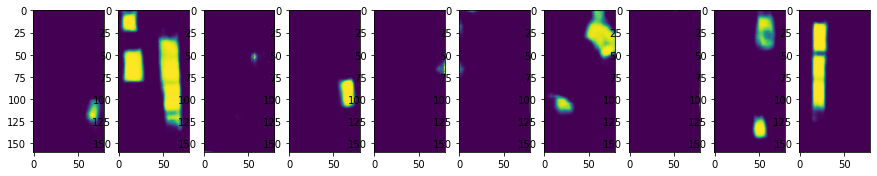

In [48]:
plt.figure()
f, axarr = plt.subplots(1,10, figsize=(15, 15))

for i in range(10):
        axarr[i].imshow(Y_pred[i+10].reshape(160,80))

<Figure size 432x288 with 0 Axes>

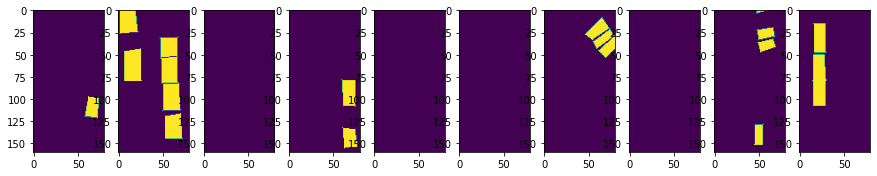

In [49]:
plt.figure()
f, axarr = plt.subplots(1,10, figsize=(15, 15))

for i in range(10):
        axarr[i].imshow(y_test[i+10].reshape(160,80))